# Energy dispersion check

This notebook checks the self consistency of the energy dispersion during event sampling. For this we compute an energy dispersion map. Then we choose one value of true energy and sample the reconstructed energy. Finally we compare against resulting distribution against the PSF contained in the energy migration matrix.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gammapy.cube import MapDataset, EDispMap, MapDatasetMaker
from gammapy.maps import MapCoord, MapAxis, WcsGeom
from gammapy.irf import EnergyDispersion2D, load_cta_irfs
from astropy.coordinates import SkyCoord
from astropy import units as u
from gammapy.data import Observation

In [3]:
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"

E_TRUE_AXIS = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=40)
E_RECO_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=30)

# this is the defaulr used in Gammapy right now
MIGRA_AXIS = MapAxis.from_bounds(0.2, 5, nbin=150, node_type="edges", name="migra")

N_EVENTS = 100_000

# idx=10 is ~1 TeV
E_TRUE = E_TRUE_AXIS.center[15]

Here we define a little helper function to compute an `EDispMap`:

In [4]:
def make_edisp_map(edisp):
    pointing = SkyCoord(1, 0, frame="galactic", unit="deg")
    irfs = load_cta_irfs(IRF_FILE)
    irfs["edisp"] = edisp
    obs = Observation.create(pointing=pointing, livetime="1 h", irfs=irfs)
    
    geom = WcsGeom.create(
        skydir=pointing, width=(1, 1), binsz=0.02, frame="galactic", axes=[E_RECO_AXIS]
    )
    dataset_empty = MapDataset.create(geom=geom, energy_axis_true=E_TRUE_AXIS, migra_axis=MIGRA_AXIS)
    
    maker = MapDatasetMaker(selection=["edisp"])
    
    dataset = maker.run(dataset_empty, obs)
    return dataset.edisp

In [5]:
def plot_edisp_comparison(e_reco_events, edisp_kernel):
    plt.figure(figsize=(12, 8))
    idx = edisp_kernel.e_true.coord_to_idx(E_TRUE)
    values = edisp_kernel.pdf_matrix[int(idx)]

    norm = 1 / (edisp_kernel.e_reco.bin_width * values).sum()
    plt.step(edisp_kernel.e_reco.edges[:-1].value, norm * values, label="Edisp kernel", where="post")
    plt.scatter(edisp_kernel.e_reco.center.value, norm * values, zorder=10)
    
    data, _ = np.histogram(e_reco_events.value, bins=edisp_kernel.e_reco.edges.value)
    norm = 1 / (edisp_kernel.e_reco.bin_width.value * data).sum()
    
    plt.step(edisp_kernel.e_reco.edges[:-1].value, data * norm, label="Sampled edisp", where="post")
    plt.vlines(E_TRUE.value, 0, (norm * values).max())
    
    mean = e_reco_events.mean()
    mean_pdf = (edisp_kernel.e_reco.center * values).sum()
    print(f"E_true      : {E_TRUE:.4f}")
    print(f"Mean samples: {mean:.4f}")
    print(f"Mean PDF    : {mean_pdf:.4f}")

    plt.semilogx()
    plt.xlim(0.4, 3)
    plt.xlabel("$E_{Reco}$ [TeV]");
    plt.legend()

In [6]:
def sample_events_e_reco(edisp_map):
    lon, lat = np.zeros(N_EVENTS), np.zeros(N_EVENTS)
    skycoord = SkyCoord(lon, lat, unit="deg", frame="galactic")
    energy = E_TRUE * np.ones(len(skycoord))
    coords = MapCoord.create({"skycoord": skycoord, "energy": energy})
    coords_reco = edisp_map.sample_coord(coords, migra_oversampling=1)
    return coords_reco["energy"]

# Diagonal energy dispersion

In [7]:
edisp_map_diag = EDispMap.from_diagonal_response(energy_axis_true=E_TRUE_AXIS, migra_axis=MIGRA_AXIS)

In [8]:
e_reco_events_diag = sample_events_e_reco(edisp_map=edisp_map_diag)

In [9]:
e_reco = MapAxis.from_energy_bounds("0.4 TeV", "2 TeV", nbin=10, per_decade=True).edges
edisp_kernel_diag = edisp_map_diag.get_edisp_kernel(
    e_reco=e_reco, position=SkyCoord(0, 0, unit="deg", frame="galactic")
)


E_true      : 1.0644 TeV
Mean samples: 1.0644 TeV
Mean PDF    : 1.1256 TeV


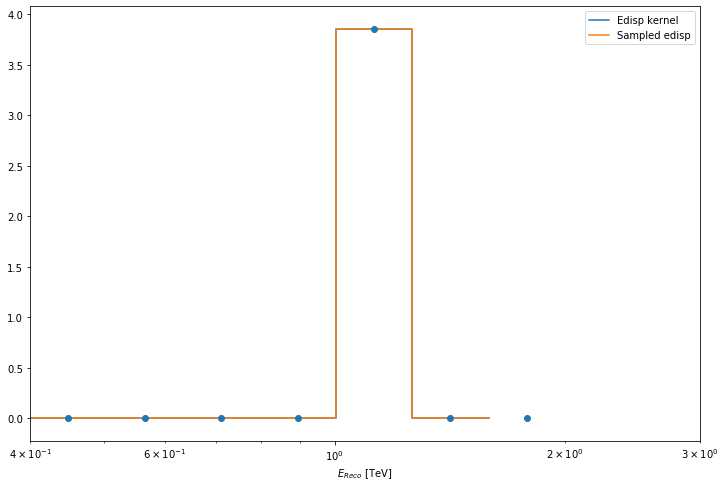

In [10]:
plot_edisp_comparison(e_reco_events_diag, edisp_kernel_diag)

## Gaussian energy dispersion

Define a Gaussian edisp which is independent of offset:

In [11]:
edisp_gauss = EnergyDispersion2D.from_gauss(
    e_true=E_TRUE_AXIS.edges, migra=MIGRA_AXIS.edges, sigma=0.1, bias=0, offset=[0, 2, 4, 6, 8] * u.deg
)

In [12]:
edisp_map_gauss = make_edisp_map(edisp=edisp_gauss)

Now we sample the reconstructed energies, assuming a true energy of `E_TRUE`:

In [13]:
e_reco_events_gauss = sample_events_e_reco(edisp_map=edisp_map_gauss)

Now we compute the edisp kernel and extract the PDF at the given true energy:

In [14]:
e_reco = MapAxis.from_energy_bounds("0.4 TeV", "2 TeV", nbin=41, per_decade=True).edges
edisp_kernel_gauss = edisp_map_gauss.get_edisp_kernel(
    e_reco=e_reco, position=SkyCoord(0, 0, unit="deg", frame="galactic")
)

Finally we plot the comparison:

E_true      : 1.0644 TeV
Mean samples: 1.0643 TeV
Mean PDF    : 1.0647 TeV


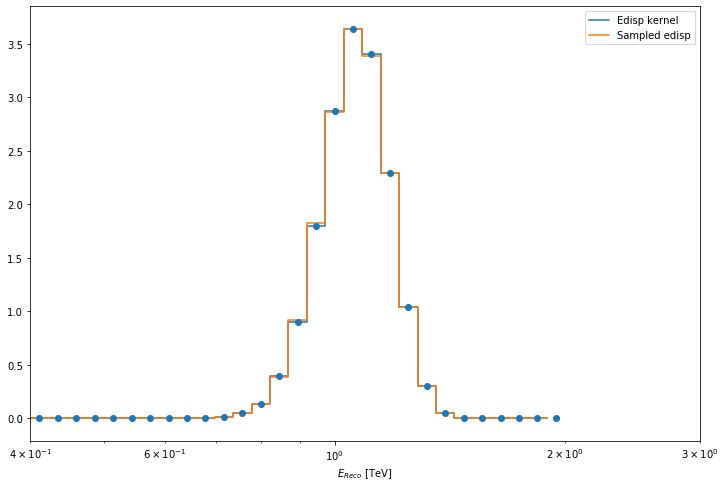

In [15]:
plot_edisp_comparison(e_reco_events_gauss, edisp_kernel_gauss)

A few things are immediately clear:
- We should use oversampling in migra, when drawing events or distribute the events linearly (not uniformly) in the migra bin
- The sampled distribution is shifted by 0.5 migra bin to the left
- The integrated PDF is also shifted (probably by 0.5 and upsampled migra bin?) to the left

## CTA energy dispersion

In [16]:
edisp_cta = load_cta_irfs(IRF_FILE)["edisp"]
edisp_map_cta = make_edisp_map(edisp=edisp_cta)
e_reco_events_cta = sample_events_e_reco(edisp_map=edisp_map_cta)

In [17]:
e_reco = MapAxis.from_energy_bounds("0.4 TeV", "2 TeV", nbin=40, per_decade=True).edges
edisp_kernel_cta = edisp_map_cta.get_edisp_kernel(
    e_reco=e_reco, position=SkyCoord(0, 0, unit="deg", frame="galactic")
)

E_true      : 1.0644 TeV
Mean samples: 1.0603 TeV
Mean PDF    : 1.0601 TeV


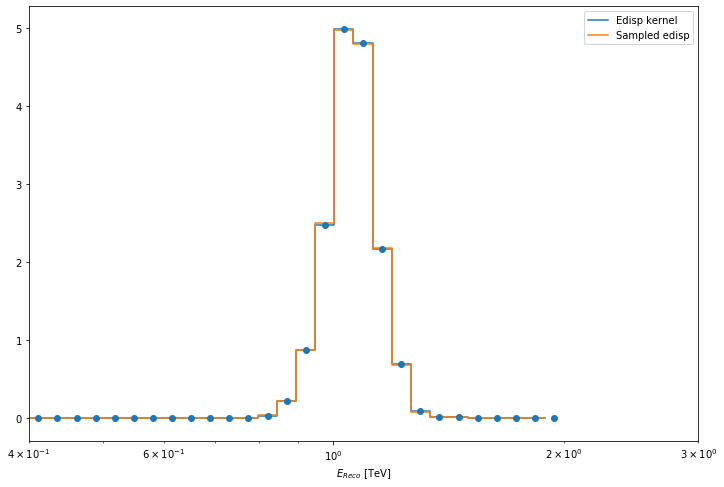

In [18]:
plot_edisp_comparison(e_reco_events_cta, edisp_kernel_cta)

Conclusions for the CTA edisp:
- The default migra binning we have in Gammapy is too coarse
- What about the outlier on the left???

# HESS Energy Dispersion

In [19]:
from gammapy.data import DataStore

In [20]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
observations = datastore.get_observations([23592, 23559])

In [21]:
edisp_hess = observations[0].edisp

In [22]:
edisp_map_hess = make_edisp_map(edisp=edisp_hess)
e_reco_events_hess = sample_events_e_reco(edisp_map=edisp_map_hess)

In [23]:
e_reco = MapAxis.from_energy_bounds("0.1 TeV", "10 TeV", nbin=50, per_decade=True).edges
edisp_kernel_hess = edisp_map_hess.get_edisp_kernel(
    e_reco=e_reco, position=SkyCoord(0, 0, unit="deg", frame="galactic")
)

E_true      : 1.0644 TeV
Mean samples: 1.1160 TeV
Mean PDF    : 1.1161 TeV


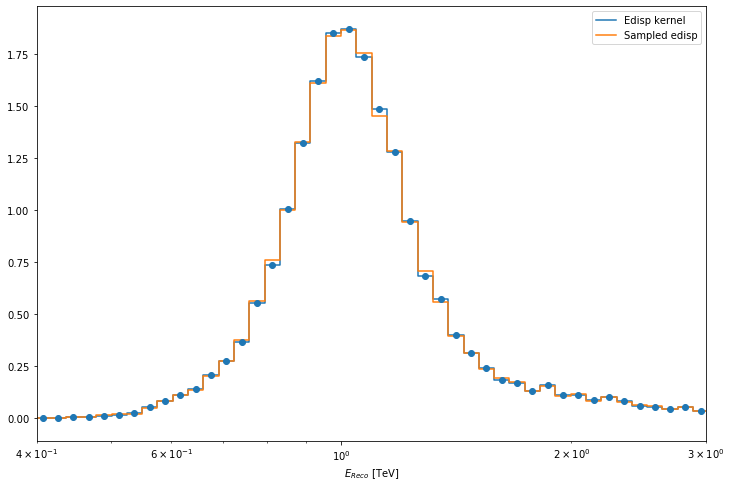

In [24]:
plot_edisp_comparison(e_reco_events_hess, edisp_kernel_hess)